# STEP 3: Finetuning LernnaviBERT on MCQs students' answers prediction

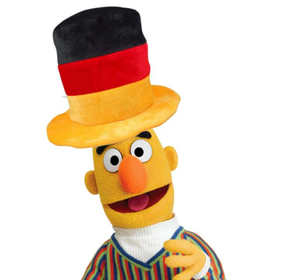

[Source of the image: https://huggingface.co/bert-base-german-cased]

In order to transform a pretrained GermanBERT model in a model able to predict the students’ answers to Multiple Choice Questions (MCQs), we decided to follow a pipeline made of three steps:
1. Finetuning GermanBERT on language modelling considering the Lernnavi dataset. The finetuned model will be renamed "LernnaviBERT" for clarity;
2. Finetuning LernnaviBERT to predict the correct answers to MCQs;
3. Further finetuning the model on the final downstream task, that is the prediction of the answers of a given student to MCQs, taking into account the embedding of the student.

In this notebook, we will perform the third step, that is finetuning MCQBert to predict the answers of the various students to MCQs, taking into account the embeddings. In particular, we will follow a procedure very similar to the one followed in the second step, but this time we will also consider the student embeddings (and we are not interested in predicting the correct answers). We will start by introducing some models based on LernnaviBERT, finetuned on predicting the correct answers to MCQs. Then, we will train the models on a training dataset, and verify the performances on a test dataset.

## Theoretical motivation

In the third and final step, we aim at finetuning the model on the final downstream task, that is predicting the answers given by students to MCQs taking into account some information from the students (in the form of embeddings). Our hypothesis is that the model can benefit from the finetuning performed in the previous steps (language modelling task and MCQs correct answer prediction) to predict the students' answers in a more accurate way.

## STEP 3

We then define a set of variables that we will need during the finetuning process.

In [1]:
BASE_DATA_DIR = "../../data"
QNA_DATA_DIR = f"{BASE_DATA_DIR}/lernnavi/qna"
ORIGINAL_DATA_DIR = f"{BASE_DATA_DIR}/original/data"

never_seen_MCQ = False
train_ratio = 0.8
splitting_tolerance = 0.02
batch_size = 16
epochs = 3
max_gradient_norm = 1.0
warmup_p = 0.3
learning_rate = 1.75e-5

Then, we import all the packages which are necessary to run the notebook.

In [2]:
import pickle
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from dataset_train_eval_extensions import QuestionsDatasetWithSyncedEmbeddings, train, generate_synced_qna_embeddings
import torch
from transformers import BertModel, AutoTokenizer, AutoConfig
import numpy as np 
import random
from huggingface_hub import notebook_login

At this point, we fix the random seed for reproducibility purposes. It should be noted, in any case, that the randomness is not completely removed, and the results may vary from run to run.

In [4]:
seed = int(0)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
print('Random seed (for reproducibility): ', seed)

Random seed (for reproducibility):  0


We load the dataset containing all the Lernnavi MCQs (questions and possible answers).

In [21]:
# with open('/content/drive/MyDrive/MLBD/datasets/Lernnavi_MCQs.pkl', 'rb') as file:
seq_len = 40
data = generate_synced_qna_embeddings(
    f'{QNA_DATA_DIR}/all_data_qna_expanded.pkl',
    f'{BASE_DATA_DIR}/lernnavi/embeddings/lstm_seq_len_{seq_len}_h_dims_1.pt',
    f'{QNA_DATA_DIR}/MULTIPLE_CHOICE_german.pkl'
)

We then preprocess the dataset containing the MCQs by selecting which columns and rows to keep and removing the HTML tags.

In [22]:
# Step 1: Select which columns to keep
data = data[["question", "choices", "student_answer", "user_id", "embeddings"]].reset_index(drop = True)

# Step 2: Remove HTML tags
data["question"] = data["question"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
data["choices"] = data["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])

/tmp/ipykernel_3068/3710378821.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data["choices"] = data["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])


At this point, we split the dataset into a train dataset and a validation/test dataset. As stated in the previous milestone, we coded two different methods to split a dataset:
- The first method splits the datasets into a train dataset and a validation/test dataset using the standard SKLearn function 'train_test_split'. Since each individual MCQ is present multiple times in the dataset (once for each time a user attempted to answer that given MCQ), using this approach the same MCQ can appear both in the train dataset and in the test dataset. In other words, the model could have already seen that particular MCQ, but not for the same student. This will be the approach that we will use in this notebook;
- The second method splits the dataset ensuring that each individual MCQ is present only in the training dataset or in the test/validation dataset. In other words, all the instances of a given MCQ are inserted in only one of the two datasets. This approach poses an additional challenge for the model, since it should generalize to an MCQ which has never seen before.

To clarify this concept, we can consider the dataset below (for clarity, each individual MCQ is characterised by the same color):

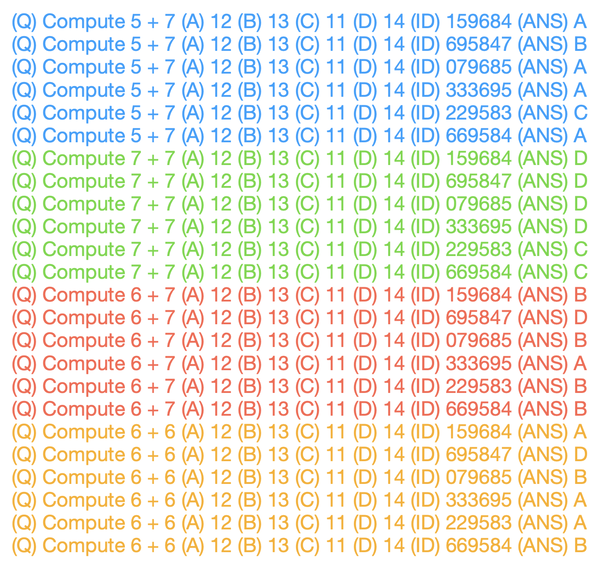

From this dataset, it is possible to see that the same MCQ is present multiple times in the dataset, as multiple students attempted to answer. If never_seen_MCQ = False (first method explained), this is a possible splitting between the training dataset and the validation dataset (train_ratio = 0.75):

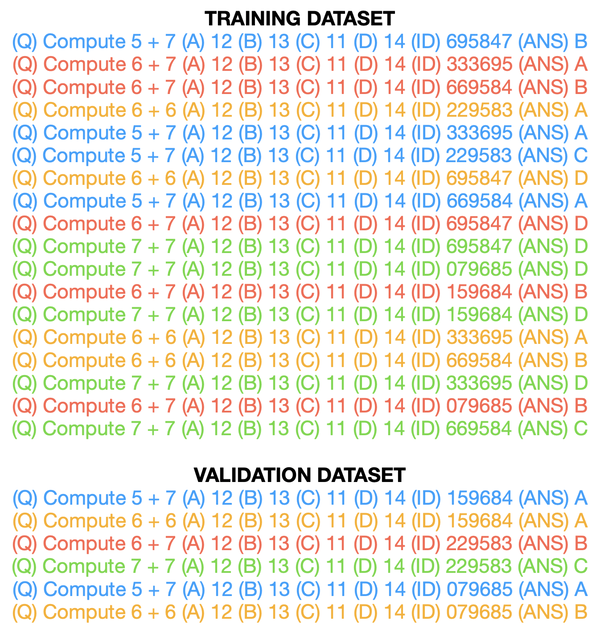

As expected, the dataset is split line by line, and each dataset can contain the same question, but for different students. If, instead, we set never_seen_MCQ = True (second method explained), this is a possible splitting between the training dataset and the validation dataset (train_ratio = 0.75):

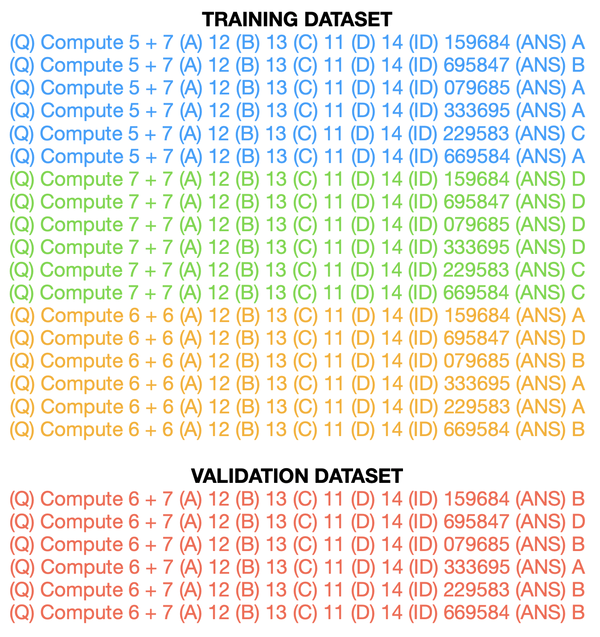

In this case, each question is appearing only in the training dataset or in the validation dataset, and the model will be evaluated on its ability to predict the student's answers to a question which it has never seen before.

In [23]:
if never_seen_MCQ == False:
    # Splitting by row
    data_train, data_val = train_test_split(data, train_size = train_ratio, random_state = seed)
else:
    # Splitting by question
    unique_questions = data['question'].unique()
    discrepancy = 1.0
    data_train = pd.DataFrame()
    data_val = pd.DataFrame()
    add_seed = 0
    # Splitting until the actual train ratio is close enough to the desired one (within splitting_tolerance)
    while abs(discrepancy) > splitting_tolerance:
        # Splitting the unique questions
        train_questions, val_questions = train_test_split(unique_questions, train_size = train_ratio, random_state = seed + add_seed)
        # Determining which rows are in the train and validation sets
        data_train = data[data['question'].isin(train_questions)]
        data_val = data[data['question'].isin(val_questions)]
        # Calculating the actual train ratio
        total_rows = len(data_train) + len(data_val)
        actual_train_ratio = len(data_train) / total_rows
        # Calculating the discrepancy
        discrepancy = actual_train_ratio - train_ratio
        add_seed = add_seed + 1
    print(f"Actual train ratio: {actual_train_ratio}")

print(f"Training set size: {len(data_train)}")
print(f"Validation set size: {len(data_val)}")

Training set size: 109965
Validation set size: 27492


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tokenizer
tok_model_name = "dbmdz/bert-base-german-uncased"
tokenizer = AutoTokenizer.from_pretrained(tok_model_name)

NameError: name 'torch' is not defined

At this point, we define the training dataset and the validation/test dataset.

In [24]:
# Training dataset with student embeddings
train_dataset = QuestionsDatasetWithSyncedEmbeddings(tokenizer, data_train)
# Validation dataset with student embeddings
dev_dataset = QuestionsDatasetWithSyncedEmbeddings(tokenizer, data_val)

109965it [01:33, 1182.12it/s]
27492it [00:25, 1088.03it/s]


In [41]:
import torch.nn as nn
from dataset_train_eval_extensions import metrics
from tqdm import tqdm

class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, *args):
        return torch.tensor([[0.]] * args[0].shape[0]).cuda()

    @property
    def classifier(self):
        return DummyModel()

model = DummyModel()
val_data=dev_dataset
train_weights=train_dataset.weights

eval_loss = 0
eval_step = 0
batch_labels = []
batch_preds = []
eval_dataloader = torch.utils.data.DataLoader(val_data, sampler=torch.utils.data.SequentialSampler(val_data), batch_size=batch_size, collate_fn=val_data.collate_batch)

# Loss function (with weights to balance the classes)
pos_weight_value = (train_weights[1] / train_weights[0])
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(device)

model.eval()

for batch in tqdm(eval_dataloader, desc="Evaluation"):
    eval_step = eval_step + 1
    with torch.no_grad():
        ids, labels, student_embeddings, student_features = tuple(input_t.to(device) for input_t in batch)
        logits = model(ids)
        loss = criterion(logits.squeeze(1), labels)
        eval_loss = eval_loss + loss.mean().item()
        batch_labels.append(labels.detach().cpu().numpy())
        batch_preds.append((logits.detach().cpu().numpy() > 0.5).astype(int))
pred_labels = np.concatenate(batch_preds)

eval_loss = eval_loss / eval_step
true_labels = list(np.concatenate(batch_labels))
acc_score, f1_0, f1_1, con_matrix, mcc = metrics(pred_labels, true_labels)

print(acc_score, f1_0, f1_1, con_matrix, mcc)

Evaluation:   0%|          | 0/6738 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 6738/6738 [01:06<00:00, 101.87it/s]


0.590900236538194 0.7428501460581785 0.0 [[63702     0]
 [44103     0]] 0.0


In [42]:
import torch.nn as nn
from dataset_train_eval_extensions import metrics
from tqdm import tqdm

class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, *args):
        return torch.tensor([[1.]] * args[0].shape[0]).cuda()

    @property
    def classifier(self):
        return DummyModel()

model = DummyModel()
val_data=dev_dataset
train_weights=train_dataset.weights

eval_loss = 0
eval_step = 0
batch_labels = []
batch_preds = []
eval_dataloader = torch.utils.data.DataLoader(val_data, sampler=torch.utils.data.SequentialSampler(val_data), batch_size=batch_size, collate_fn=val_data.collate_batch)

# Loss function (with weights to balance the classes)
pos_weight_value = (train_weights[1] / train_weights[0])
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(device)

model.eval()

for batch in tqdm(eval_dataloader, desc="Evaluation"):
    eval_step = eval_step + 1
    with torch.no_grad():
        ids, labels, student_embeddings, student_features = tuple(input_t.to(device) for input_t in batch)
        logits = model(ids)
        loss = criterion(logits.squeeze(1), labels)
        eval_loss = eval_loss + loss.mean().item()
        batch_labels.append(labels.detach().cpu().numpy())
        batch_preds.append((logits.detach().cpu().numpy() > 0.5).astype(int))
pred_labels = np.concatenate(batch_preds)

eval_loss = eval_loss / eval_step
true_labels = list(np.concatenate(batch_labels))
acc_score, f1_0, f1_1, con_matrix, mcc = metrics(pred_labels, true_labels)

print(acc_score, f1_0, f1_1, con_matrix, mcc)

Evaluation: 100%|██████████| 6738/6738 [01:04<00:00, 104.02it/s]


0.40909976346180604 0.0 0.5806540801011139 [[    0 63702]
 [    0 44103]] 0.0
